In [2]:
!pip config set global.index-url https://mirrors.aliyun.com/pypi/simple/
!python -m pip install -U pip
!pip -V
!pip install sklearn pandas

Writing to /root/.config/pip/pip.conf
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)
pip 20.2.4 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.5
pandas 1.1.3
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [9]:
source_dir = './generate_csv/'

def get_filename_by_prefix(source_dir, prefix_name):
    all_files = os.listdir(source_dir)
    results = []
    for filename in all_files:
        if filename.startswith(prefix_name):
            results.append(os.path.join(source_dir, filename))            
    return results

train_filenames = get_filename_by_prefix(source_dir, 'train')
valid_filenames = get_filename_by_prefix(source_dir, 'valid')
test_filenames = get_filename_by_prefix(source_dir, 'test')

from pprint import pprint
pprint(train_filenames)
pprint(valid_filenames)
pprint(test_filenames)

['./generate_csv/train_00.csv',
 './generate_csv/train_01.csv',
 './generate_csv/train_02.csv',
 './generate_csv/train_03.csv',
 './generate_csv/train_04.csv',
 './generate_csv/train_05.csv',
 './generate_csv/train_06.csv',
 './generate_csv/train_07.csv',
 './generate_csv/train_08.csv',
 './generate_csv/train_09.csv',
 './generate_csv/train_10.csv',
 './generate_csv/train_11.csv',
 './generate_csv/train_12.csv',
 './generate_csv/train_13.csv',
 './generate_csv/train_14.csv',
 './generate_csv/train_15.csv',
 './generate_csv/train_16.csv',
 './generate_csv/train_17.csv',
 './generate_csv/train_18.csv',
 './generate_csv/train_19.csv']
['./generate_csv/valid_00.csv',
 './generate_csv/valid_01.csv',
 './generate_csv/valid_02.csv',
 './generate_csv/valid_03.csv',
 './generate_csv/valid_04.csv',
 './generate_csv/valid_05.csv',
 './generate_csv/valid_06.csv',
 './generate_csv/valid_07.csv',
 './generate_csv/valid_08.csv',
 './generate_csv/valid_09.csv']
['./generate_csv/test_00.csv',
 './gener

In [13]:
def parse_csv_line(line, n_fields=9):
    defs = [tf.constant(np.nan)] * n_fields
    parsed_fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(parsed_fields[0:-1])
    y = tf.stack(parsed_fields[-1:])
    return x, y

def csv_reader_dataset(filenames, n_readers=5, 
                       batch_size=32, n_parse_threads=5,
                       shuffle_buffer_size=10000):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename).skip(1),
        cycle_length = n_readers
    )
    dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse_csv_line, 
                          num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset

batch_size = 32
train_set = csv_reader_dataset(train_filenames, batch_size=batch_size)
valid_set = csv_reader_dataset(valid_filenames, batch_size=batch_size)
test_set = csv_reader_dataset(test_filenames, batch_size=batch_size)

In [20]:
def serialize_exmaple(x, y):
    '''Converts x,y to tf.train.Example and serialize'''
    input_features = tf.train.FloatList(value = x)
    label = tf.train.FloatList(value = y)
    features = tf.train.Features(
        feature = {
            'input_features': tf.train.Feature(float_list = input_features),
            'label': tf.train.Feature(float_list = label)
        }
    )
    example = tf.train.Example(features = features)
    return example.SerializeToString()

def csv_dataset_to_tfrecords(base_filename, dataset, n_shards, steps_per_shard,
                           compression_type = None):
    options = tf.io.TFRecordOptions(compression_type=compression_type)
    all_filenames = []
    for shard_id in range(n_shards):
        filename_fullpath = '{}_{:05d}-of-{:05d}'.format(
            base_filename, shard_id, n_shards)
        with tf.io.TFRecordWriter(filename_fullpath, options) as writer:
            for x_batch, y_batch in dataset.take(steps_per_shard):
                for x_example, y_exmaple in zip(x_batch, y_batch):
                    writer.write(
                        serialize_exmaple(x_example, y_exmaple))
        all_filenames.append(filename_fullpath)
    return all_filenames

In [21]:
n_shards = 20
train_steps_per_shard = 11610 // batch_size // n_shards
valid_steps_per_shard = 3880 // batch_size // n_shards
test_steps_per_shard = 5170 // batch_size // n_shards

output_dir = 'generate_tfrecords'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
train_basename = os.path.join(output_dir, 'train')
valid_basename = os.path.join(output_dir, 'valid')
test_basename = os.path.join(output_dir, 'test')

train_tfrecord_filenames = csv_dataset_to_tfrecords(
    train_basename, train_set, n_shards, train_steps_per_shard, None)
valid_tfrecord_filenames = csv_dataset_to_tfrecords(
    valid_basename, valid_set, n_shards, valid_steps_per_shard, None)
test_tfrecord_filenames = csv_dataset_to_tfrecords(
    test_basename, test_set, n_shards, test_steps_per_shard, None)

In [22]:
n_shards = 20
train_steps_per_shard = 11610 // batch_size // n_shards
valid_steps_per_shard = 3880 // batch_size // n_shards
test_steps_per_shard = 5170 // batch_size // n_shards

output_dir = 'generate_tfrecords_zip'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
train_basename = os.path.join(output_dir, 'train')
valid_basename = os.path.join(output_dir, 'valid')
test_basename = os.path.join(output_dir, 'test')

train_tfrecord_filenames = csv_dataset_to_tfrecords(
    train_basename, train_set, n_shards, train_steps_per_shard, 'GZIP')
valid_tfrecord_filenames = csv_dataset_to_tfrecords(
    valid_basename, valid_set, n_shards, valid_steps_per_shard, 'GZIP')
test_tfrecord_filenames = csv_dataset_to_tfrecords(
    test_basename, test_set, n_shards, test_steps_per_shard, 'GZIP')

In [23]:
pprint(train_tfrecord_filenames)
pprint(valid_tfrecord_filenames)
pprint(test_tfrecord_filenames)

['generate_tfrecords_zip/train_00000-of-00020',
 'generate_tfrecords_zip/train_00001-of-00020',
 'generate_tfrecords_zip/train_00002-of-00020',
 'generate_tfrecords_zip/train_00003-of-00020',
 'generate_tfrecords_zip/train_00004-of-00020',
 'generate_tfrecords_zip/train_00005-of-00020',
 'generate_tfrecords_zip/train_00006-of-00020',
 'generate_tfrecords_zip/train_00007-of-00020',
 'generate_tfrecords_zip/train_00008-of-00020',
 'generate_tfrecords_zip/train_00009-of-00020',
 'generate_tfrecords_zip/train_00010-of-00020',
 'generate_tfrecords_zip/train_00011-of-00020',
 'generate_tfrecords_zip/train_00012-of-00020',
 'generate_tfrecords_zip/train_00013-of-00020',
 'generate_tfrecords_zip/train_00014-of-00020',
 'generate_tfrecords_zip/train_00015-of-00020',
 'generate_tfrecords_zip/train_00016-of-00020',
 'generate_tfrecords_zip/train_00017-of-00020',
 'generate_tfrecords_zip/train_00018-of-00020',
 'generate_tfrecords_zip/train_00019-of-00020']
['generate_tfrecords_zip/valid_00000-of-

In [26]:
expected_features = {
    'input_features': tf.io.FixedLenFeature([8], dtype=tf.float32),
    'label': tf.io.FixedLenFeature([1], dtype=tf.float32)
}

def parse_example(serialized_example):
    example = tf.io.parse_single_example(serialized_example, expected_features)
    return example['input_features'], example['label']

def tfrecord_reader_dataset(filenames, n_readers=5, 
                       batch_size=32, n_parse_threads=5,
                       shuffle_buffer_size=10000):
    
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TFRecordDataset(
            filename, compression_type='GZIP'),
        cycle_length = n_readers
    )
    dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse_example, 
                          num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset

tfrecords_train = tfrecord_reader_dataset(train_tfrecord_filenames, batch_size=3)
for x_batch, y_batch in tfrecords_train.take(2):
    print(x_batch, y_batch)

tf.Tensor(
[[ 0.15782312  0.4323619   0.3379948  -0.01588031 -0.37338907 -0.05305246
   0.80061346 -1.2359096 ]
 [ 0.4240821   0.91296333 -0.04437482 -0.15297213 -0.24727628 -0.10539167
   0.86126745 -1.335779  ]
 [-0.32652634  0.4323619  -0.09345459 -0.08402992  0.8460036  -0.02663165
  -0.56176794  0.1422876 ]], shape=(3, 8), dtype=float32) tf.Tensor(
[[3.169]
 [3.955]
 [2.431]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[-1.1199750e+00 -1.3298433e+00  1.4190045e-01  4.6581370e-01
  -1.0301778e-01 -1.0744184e-01 -7.9505241e-01  1.5304717e+00]
 [ 2.5150437e+00  1.0731637e+00  5.5744010e-01 -1.7273512e-01
  -6.1291260e-01 -1.9091565e-02 -5.7109928e-01 -2.7490310e-02]
 [ 4.9710345e-02 -8.4924191e-01 -6.2146995e-02  1.7878747e-01
  -8.0253541e-01  5.0660671e-04  6.4664572e-01 -1.1060793e+00]], shape=(3, 8), dtype=float32) tf.Tensor(
[[0.66   ]
 [5.00001]
 [2.286  ]], shape=(3, 1), dtype=float32)


In [27]:
batch_size = 32
train_set = tfrecord_reader_dataset(train_tfrecord_filenames, batch_size=batch_size)
valid_set = tfrecord_reader_dataset(train_tfrecord_filenames, batch_size=batch_size)
test_set = tfrecord_reader_dataset(train_tfrecord_filenames, batch_size=batch_size)

In [28]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu',
                      input_shape=[8]),
    keras.layers.Dense(1),
])
model.compile(loss='mean_squared_error', optimizer='sgd')
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)
]

In [29]:
history = model.fit(train_set,
                   validation_data=valid_set,
                   steps_per_epoch=11160 // batch_size,
                    validation_steps =3780 // batch_size,
                   epochs=100,
                   callbacks=callbacks)

Epoch 1/100
348/348 [==============================] - 0s 1ms/step - loss: 0.8497 - val_loss: 0.7493
Epoch 2/100
348/348 [==============================] - 0s 985us/step - loss: 0.5826 - val_loss: 0.4249
Epoch 3/100
348/348 [==============================] - 0s 961us/step - loss: 0.4312 - val_loss: 0.4150
Epoch 4/100
348/348 [==============================] - 0s 960us/step - loss: 0.4065 - val_loss: 0.3959
Epoch 5/100
348/348 [==============================] - 0s 972us/step - loss: 0.3965 - val_loss: 0.3843
Epoch 6/100
348/348 [==============================] - 0s 958us/step - loss: 0.3833 - val_loss: 0.3846
Epoch 7/100
348/348 [==============================] - 0s 994us/step - loss: 0.3779 - val_loss: 0.3728
Epoch 8/100
348/348 [==============================] - 0s 958us/step - loss: 0.3521 - val_loss: 0.3684
Epoch 9/100
348/348 [==============================] - 0s 930us/step - loss: 0.3566 - val_loss: 0.3486
Epoch 10/100
348/348 [==============================] - 0s 960us/step - los

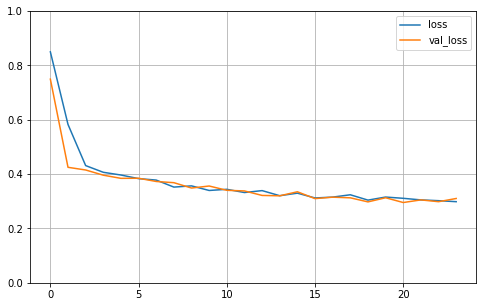

In [30]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [31]:
model.evaluate(test_set, steps = 5160 // batch_size)

161/161 [==============================] - 0s 687us/step - loss: 0.2942


0.29422929883003235